In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_circles
from sklearn.metrics import accuracy_score, log_loss
from tqdm import tqdm

In [5]:
def initialisation(dimensions):
    parametres = {}
    C= len(dimensions)
    print(C)
    for c in range (1,C):
        parametres['w'+ str(c)] = np.random.randn(dimensions[c],dimensions[c-1])
        parametres['b'+ str(c)] = np.random.randn(dimensions[c],1)
    return parametres

In [15]:
parametres = initialisation([2,32,32,1])
for key,val in parametres.items():
    print(key,val.shape)

print(int(len(parametres) / 2))

4
w1 (32, 2)
b1 (32, 1)
w2 (32, 32)
b2 (32, 1)
w3 (1, 32)
b3 (1, 1)
3


In [14]:
def forward_propagation(X, parametres):
    activations = {'A0':X}
    for p in range(1,int(len(parametres) // 2)+1):
        wp = parametres['w'+str(p)]
        bp = parametres['b'+str(p)]

        Zp = wp.dot(activations['A'+str(p-1)]) + bp 
        activations['A'+str(p)] = 1 / (1 + np.exp(-Zp))

    return activations

In [28]:
X, y = make_blobs(n_samples=100, n_features=2, centers=2, random_state=0)
X = X.T
y = y.reshape(1,y.shape[0])

In [25]:
activations = forward_propagation(X,parametres)
for key,val in activations.items():
    print(key,val.shape)

A0 (2, 100)
A1 (32, 100)
A2 (32, 100)
A3 (1, 100)


In [33]:
def back_propagation(X, y, parametres, activations):
    m = y.shape[1]
    C = len(parametres) // 2
    dZ = activations['A'+str(C)] - y
    gradients = {}

    for c in reversed(range(1,C + 1)):
        gradients['dw'+str(c)] = 1 / m * np.dot(dZ,activations['A'+str(c-1)].T)
        gradients['db'+str(c)] = 1 / m * np.sum(dZ,axis=1, keepdims = True)
        if c>1 :
            dZ = np.dot(parametres['w'+str(c)].T,dZ) * activations['A'+str(c-1)] * (1 - activations['A'+str(c-1)])
    
    return gradients

In [35]:
grad = back_propagation(X,y,parametres,activations)

for key,val in grad.items():
    print(key,val.shape)

dw3 (1, 32)
db3 (1, 1)
dw2 (32, 32)
db2 (32, 1)
dw1 (32, 2)
db1 (32, 1)


In [43]:
def update(gradients, parametres, learning_rate):

    C = len(parametres) // 2
    
    for c in range(1,C+1):
        parametres['w'+str(c)] = parametres['w'+str(c)] - learning_rate * gradients['dw'+str(c)]
        parametres['b'+str(c)] = parametres['b'+str(c)] - learning_rate * gradients['db'+str(c)]

    return parametres


In [47]:
def predict(X, parametres):
  activations = forward_propagation(X, parametres)
  C = len(parametres) // 2
  return activations['A'+str(C)] >= 0.5

In [49]:
def visualisation(X, y, parametres, ax):
    # Création d'une grille de points sur le plan
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    
    # Formattage des points en colonnes pour les passer au réseau
    grid = np.c_[xx.ravel(), yy.ravel()].T  # shape (2, nb_points)
    
    # Prédiction sur la grille
    Z = predict(grid, parametres)  # shape (1, nb_points)
    Z = Z.reshape(xx.shape)
    
    # Affichage de la frontière
    ax[2].contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Spectral)
    
    # Affichage des vraies données
    ax[2].scatter(X[0, :], X[1, :], c=y.flatten(), cmap=plt.cm.Spectral, s=20)
    ax[2].set_title("Frontière de décision")

In [60]:
def neural_network(X, y, hidden_layers = (16,32,16), learning_rate = 0.01, n_iter = 5000):

    # initialisation parametres
    dimensions = list(hidden_layers)
    dimensions.insert(0,X.shape[0])
    dimensions.append(y.shape[0])
    parametres = initialisation(dimensions)

    train_loss = []
    train_acc = []
    history = []

    # gradient descent
    for i in tqdm(range(n_iter)):
        activations = forward_propagation(X, parametres)
        gradients = back_propagation(X,y,parametres,activations)
        parametres = update(gradients,parametres,learning_rate)

        if i%10 == 0:
        # Plot courbe d'apprentissage
            C = len(parametres) // 2
            train_loss.append(log_loss(y.flatten(), activations['A'+str(C)].flatten()))
            y_pred = predict(X, parametres)
            train_acc.append(accuracy_score(y.flatten(), y_pred.flatten()))


    fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(18,4))
    ax[0].plot(train_loss,label='train loss')
    ax[0].legend()
    ax[1].plot(train_acc,label='train accuracy')
    ax[1].legend()
    visualisation(X,y,parametres,ax)
    plt.show()

    return parametres

In [50]:
# def neural_network(X, y, hidden_layers = (32,32,32), learning_rate = 0.01, n_iter = 8000):

#     # initialisation parametres
#     dimensions = list(hidden_layers)
#     dimensions.insert(0,X.shape[0])
#     dimensions.append(y.shape[0])
#     parametres = initialisation(dimensions)
#     training_history = np.zeros((int(n_iter), 2))
#     C = len(parametres) // 2

#     # gradient descent
#     for i in tqdm(range(n_iter)):
#         activations = forward_propagation(X, parametres)
#         gradients = back_propagation(X,y,parametres,activations)
#         parametres = update(gradients,parametres,learning_rate)

#         training_history[i, 0] = (log_loss(y.flatten(), activations['A'+str(C)].flatten()))
#         y_pred = predict(X, parametres)
#         training_history[i, 1] = (accuracy_score(y.flatten(), y_pred.flatten()))

#     # Plot courbe d'apprentissage
#     plt.figure(figsize=(12, 4))
#     plt.subplot(1, 2, 1)
#     plt.plot(training_history[:, 0], label='train loss')
#     plt.legend()
#     plt.subplot(1, 2, 2)
#     plt.plot(training_history[:, 1], label='train acc')
#     plt.legend()
#     plt.show()

#     return training_history

dimensions de X: (2, 100)
dimensions de y: (1, 100)


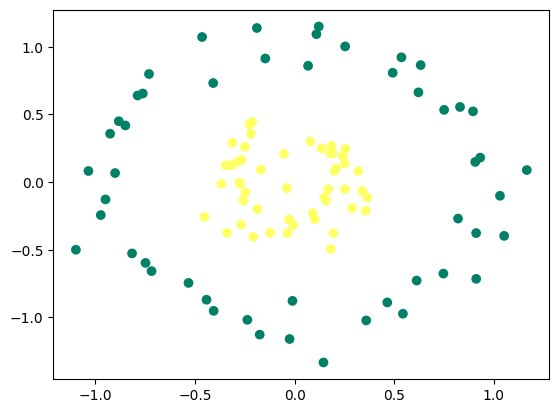

In [38]:
X, y = make_circles(n_samples=100, noise=0.1, factor=0.3, random_state=0)
X = X.T
y = y.reshape((1, y.shape[0]))

print('dimensions de X:', X.shape)
print('dimensions de y:', y.shape)

plt.scatter(X[0, :], X[1, :], c=y, cmap='summer')
plt.show()

5


100%|██████████| 5000/5000 [00:03<00:00, 1443.73it/s]


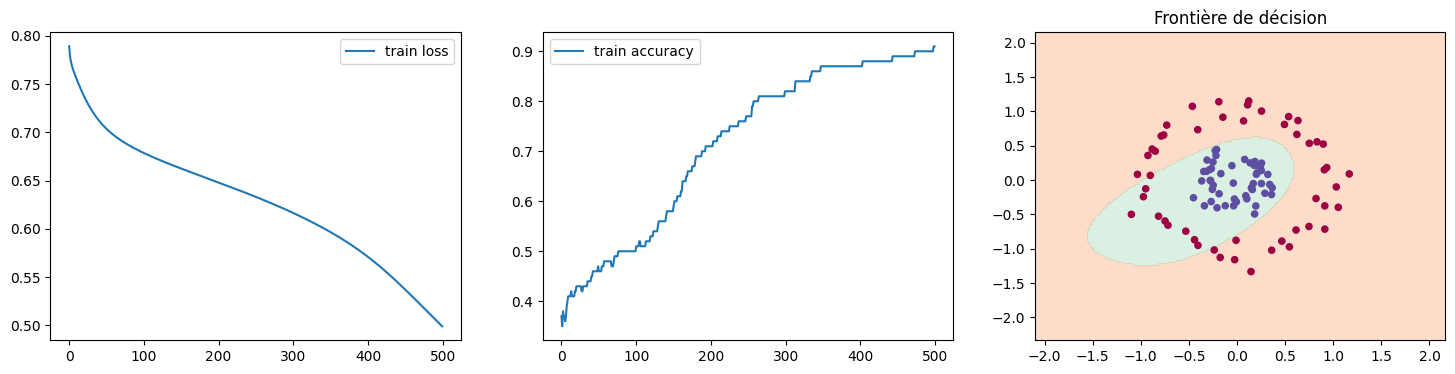

{'w1': array([[-0.30337469, -0.40292885],
        [ 0.01847032,  2.82411534],
        [-0.65629374, -1.22144574],
        [ 0.88888208, -2.06745506],
        [ 0.15934105,  0.61349976],
        [ 0.49820145, -0.20408964],
        [-0.93027992, -0.02836841],
        [ 1.33874956, -2.95745902],
        [-0.14974296, -0.11568233],
        [-0.06439654,  0.4197126 ],
        [-0.23466838,  0.20218945],
        [ 0.23794753, -0.0979431 ],
        [ 1.49522391, -0.38253177],
        [-0.14493742,  1.24404745],
        [-1.62924399,  0.54838859],
        [-0.54563184,  1.28505402]]),
 'b1': array([[-1.08177884],
        [-1.31091257],
        [-0.7097609 ],
        [-1.96197086],
        [-1.76965326],
        [-0.2351446 ],
        [-1.28264977],
        [ 1.65595495],
        [-0.65104252],
        [ 0.65431682],
        [-0.02722816],
        [ 0.37789194],
        [-0.63576446],
        [ 0.73357425],
        [ 0.21471645],
        [-0.01783363]]),
 'w2': array([[ 0.40695569, -0.32267852,

In [61]:
neural_network(X,y)